# I. Loading + Saving Data

### i. Get Data

- Loading Data as Numpy Arrays or Tensors 
- Visualizing Data with Matplotlib

In [1]:
import os 
import glob 
import numpy as np 
import torch 
from PIL import Image 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import random 


In [2]:
# GLOBAL VARIABLES
MRI_DIR = "/export1/project/mingi/Dataset/brainMRI"

In [3]:
def load_img_to_tensor(source_dir, max_images=1000000, normalize=True, target_size=None, data_type = "tensor"):
    png_images = glob.glob(os.path.join(source_dir, "**/*.png"), recursive=True) 
    
    images = []

    for file_name in tqdm(png_images[:max_images], desc="Loading images"):

        try:
            img = Image.open(file_name) 
            
            if target_size is not None: 
                img = img.resize(target_size, Image.LANCZOS)

            # Convert to numpy array 
            img_array = np.array(img)
            
            if normalize: 
                img_array = img_array.astype(np.float64) / 255.0
            else: 
                img_array = img_array.astype(np.float64)
                
            images.append(img_array) 
            
            if (len(images) >= max_images):
                break
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            continue
    
    if not images:
        raise ValueError("No images found in the specified directory.")
    images = random.sample(images, len(images))  # Shuffle the images randomly

    
    if data_type == "tensor":
        device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
        images_numpy = np.array(images, dtype=np.float64)
        
        images_tensor = torch.from_numpy(images_numpy).float().to(device)

        if len(images_tensor.shape) == 3:
            images_tensor = images_tensor.unsqueeze(1)
            
        return images_tensor
    elif data_type == "numpy":
        images_numpy = np.array(images, dtype=np.float64)
        return images_numpy

In [4]:
def visualize_images(images, num_images, figsize=(18, 18), title="MRI Images", cmap='gray', normalize=False, save_path=None):
    
    # convert to numpy if tensor
    if torch.is_tensor(images): 
        images = images.detach().cpu().numpy() 
    
    # remove channel dimension if exists 
    if len(images.shape) == 4: 
        images = images.squeeze(1)
        
    # Grid Size 
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    if grid_size == 1: 
        axes = [axes]
    else: 
        axes = axes.flatten() 
        
    for i in range(num_images):
        img = images[i]
        
        if normalize: 
            img = (img - np.min(img)) / (np.max(img) - np.min(img))

        axes[i].imshow(img, cmap=cmap)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show() 


Loading images:  98%|█████████▊| 49/50 [00:00<00:00, 912.55it/s]


Loaded 50 images of shape torch.Size([50, 1, 320, 320])


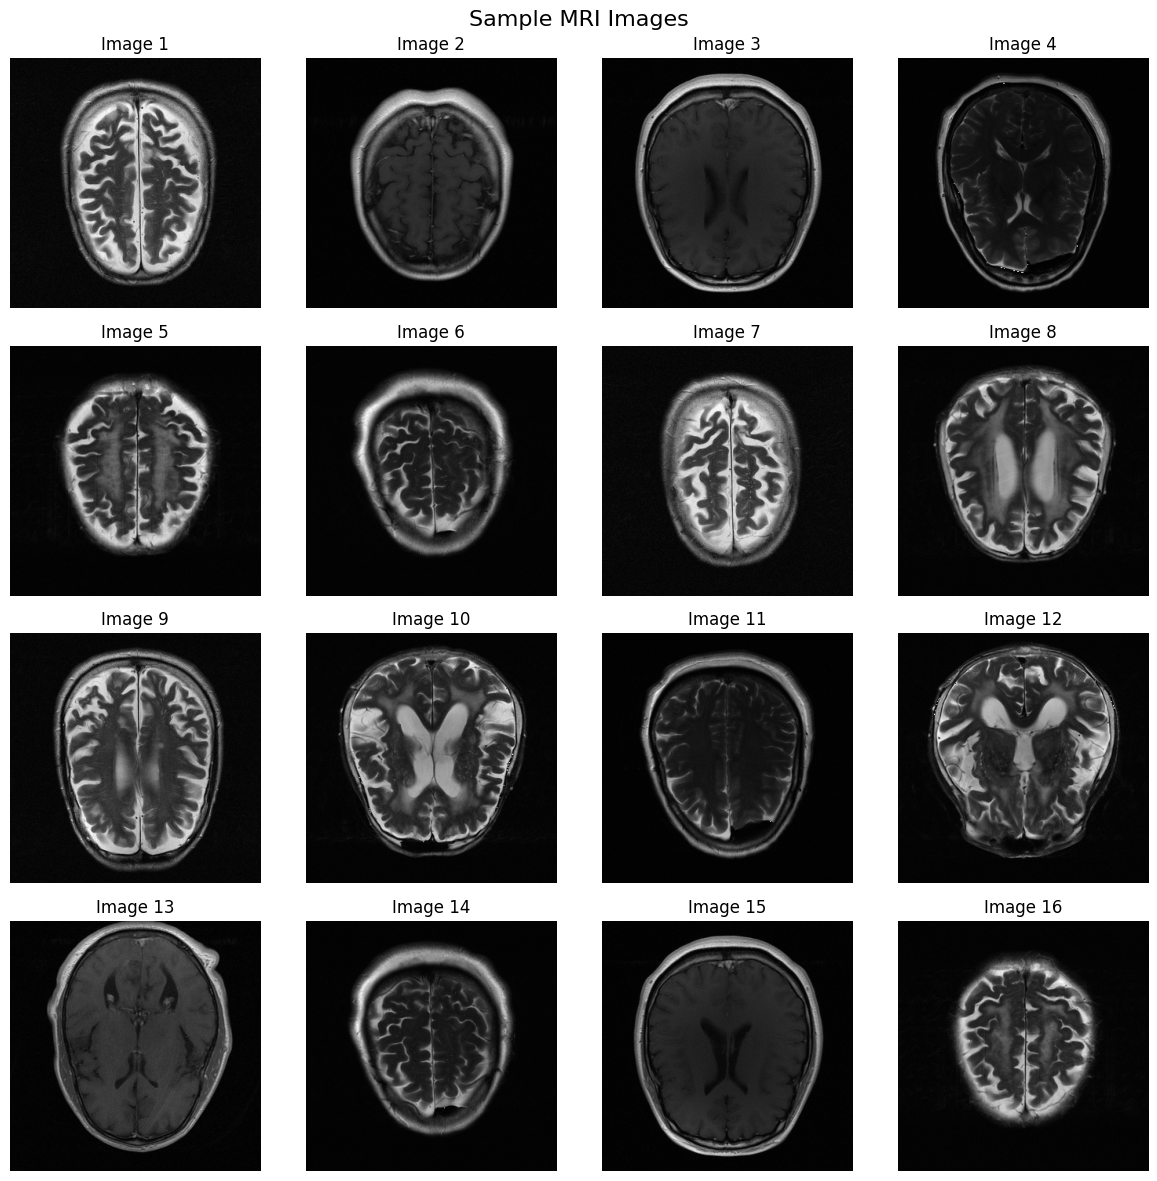

In [5]:

source_dir = MRI_DIR 
max_images = 50
target_size = (320, 320)  # Resize to 320x320
data_type = "tensor"  # or "numpy"

images = load_img_to_tensor(source_dir, max_images=max_images, target_size=target_size, data_type=data_type)

print(f"Loaded {len(images)} images of shape {images.shape}")

visualize_images(images, num_images=16, figsize=(12, 12), title="Sample MRI Images", normalize=True)

### ii. Getting Mask

In [6]:
from abc import ABC, abstractmethod
from typing import List, Optional

In [7]:

def shufflerow(tensor, axis):
    row_perm = torch.rand(tensor.shape[:axis+1]).argsort(axis).to(tensor.device) # get permutation indices
    for _ in range(tensor.ndim-axis-1): row_perm.unsqueeze_(-1)
    row_perm = row_perm.repeat(*[1 for _ in range(axis+1)], *(tensor.shape[axis+1:]))  # reformat this for the gather operation
    return tensor.gather(axis, row_perm)


def get_mask(batch_size=1, acs_lines=30, total_lines=320, R=1):
    # Overall sampling budget
    num_sampled_lines = total_lines // R

    # Get locations of ACS lines
    # !!! Assumes k-space is even sized and centered, true for fastMRI
    center_line_idx = torch.arange((total_lines - acs_lines) // 2,
                                (total_lines + acs_lines) // 2)

    # Find remaining candidates
    outer_line_idx = torch.cat([torch.arange(0, (total_lines - acs_lines) // 2), torch.arange((total_lines + acs_lines) // 2, total_lines)])
    random_line_idx = shufflerow(outer_line_idx.unsqueeze(0).repeat([batch_size, 1]), 1)[:, : num_sampled_lines - acs_lines]
    # random_line_idx = outer_line_idx[torch.randperm(outer_line_idx.shape[0])[:num_sampled_lines - acs_lines]]

    # Create a mask and place ones at the right locations
    mask = torch.zeros((batch_size, total_lines))
    mask[:, center_line_idx] = 1.
    mask[torch.arange(batch_size).repeat_interleave(random_line_idx.shape[-1]), random_line_idx.reshape(-1)] = 1.

    return mask


In [8]:

class LinearOperator(ABC):
    @abstractmethod
    def forward(self, data, **kwargs):
        # calculate A * X
        pass

    @abstractmethod
    def transpose(self, data, **kwargs):
        # calculate A^T * X
        pass
    
    def ortho_project(self, data, **kwargs):
        # calculate (I - A^T * A)X
        return data - self.transpose(self.forward(data, **kwargs), **kwargs)

    def project(self, data, measurement, **kwargs):
        # calculate (I - A^T * A)Y - AX
        return self.ortho_project(measurement, **kwargs) - self.forward(data, **kwargs)


In [9]:
## Helper functions for new types of inverse problems. 

def roll(
    x: torch.Tensor,
    shift: List[int],
    dim: List[int],
) -> torch.Tensor:
    """
    Similar to np.roll but applies to PyTorch Tensors.
    Args:
        x: A PyTorch tensor.
        shift: Amount to roll.
        dim: Which dimension to roll.
    Returns:
        Rolled version of x.
    """
    if len(shift) != len(dim):
        raise ValueError("len(shift) must match len(dim)")

    for (s, d) in zip(shift, dim):
        x = roll_one_dim(x, s, d)

    return x
  
  
def roll_one_dim(x: torch.Tensor, shift: int, dim: int) -> torch.Tensor:
    """
    Similar to roll but for only one dim.
    Args:
        x: A PyTorch tensor.
        shift: Amount to roll.
        dim: Which dimension to roll.
    Returns:
        Rolled version of x.
    """
    shift = shift % x.size(dim)
    if shift == 0:
        return x

    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)

    return torch.cat((right, left), dim=dim)

def fftshift(x: torch.Tensor, dim: Optional[List[int]] = None) -> torch.Tensor:
    """
    Similar to np.fft.fftshift but applies to PyTorch Tensors
    Args:
        x: A PyTorch tensor.
        dim: Which dimension to fftshift.
    Returns:
        fftshifted version of x.
    """
    if dim is None:
        # this weird code is necessary for toch.jit.script typing
        dim = [0] * (x.dim())
        for i in range(1, x.dim()):
            dim[i] = i

    # also necessary for torch.jit.script
    shift = [0] * len(dim)
    for i, dim_num in enumerate(dim):
        shift[i] = x.shape[dim_num] // 2

    return roll(x, shift, dim)


def ifftshift(x: torch.Tensor, dim: Optional[List[int]] = None) -> torch.Tensor:
    """
    Similar to np.fft.ifftshift but applies to PyTorch Tensors
    Args:
        x: A PyTorch tensor.
        dim: Which dimension to ifftshift.
    Returns:
        ifftshifted version of x.
    """
    if dim is None:
        # this weird code is necessary for toch.jit.script typing
        dim = [0] * (x.dim())
        for i in range(1, x.dim()):
            dim[i] = i

    # also necessary for torch.jit.script
    shift = [0] * len(dim)
    for i, dim_num in enumerate(dim):
        shift[i] = (x.shape[dim_num] + 1) // 2

    return roll(x, shift, dim)
  
def ifft2c_new(data: torch.Tensor, norm: str = "ortho") -> torch.Tensor:
    """
    Apply centered 2-dimensional Inverse Fast Fourier Transform.
    Args:
        data: Complex valued input data containing at least 3 dimensions:
            dimensions -3 & -2 are spatial dimensions and dimension -1 has size
            2. All other dimensions are assumed to be batch dimensions.
        norm: Normalization mode. See ``torch.fft.ifft``.
    Returns:
        The IFFT of the input.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    data = ifftshift(data, dim=[-3, -2])
    data = torch.view_as_real(
        torch.fft.ifftn(  # type: ignore
            torch.view_as_complex(data), dim=(-2, -1), norm=norm
        )
    )
    data = fftshift(data, dim=[-3, -2])

    return data


def ifft2_m(x):
  """ IFFT for multi-coil """
  if not torch.is_complex(x):
      x = x.type(torch.complex64)
  return torch.view_as_complex(ifft2c_new(torch.view_as_real(x)))


def fft2c_new(data: torch.Tensor, norm: str = "ortho") -> torch.Tensor:
    """
    Apply centered 2 dimensional Fast Fourier Transform.
    Args:
        data: Complex valued input data containing at least 3 dimensions:
            dimensions -3 & -2 are spatial dimensions and dimension -1 has size
            2. All other dimensions are assumed to be batch dimensions.
        norm: Normalization mode. See ``torch.fft.fft``.
    Returns:
        The FFT of the input.
    """
    if not data.shape[-1] == 2:
        raise ValueError("Tensor does not have separate complex dim.")

    data = ifftshift(data, dim=[-3, -2])
    data = torch.view_as_real(
        torch.fft.fftn(  # type: ignore
            torch.view_as_complex(data), dim=(-2, -1), norm=norm
        )
    )
    data = fftshift(data, dim=[-3, -2])

    return data



def fft2_m(x):
  """ FFT for multi-coil """
  if not torch.is_complex(x):
      x = x.type(torch.complex64)
  return torch.view_as_complex(fft2c_new(torch.view_as_real(x)))




In [10]:
class MRIOperator(LinearOperator):
    def __init__(self, acc, device, batch_size =1):
        self.device = device
        mask = get_mask(batch_size=batch_size, R=acc).unsqueeze(1).unsqueeze(1).to(device)
        self.mask = mask.expand(-1, 1, 320, -1)


    def forward(self, data, **kwargs):
        im = torch.complex(data, torch.zeros_like(data))
        return fft2_m(im) * self.mask


    def transpose(self, data, **kwargs):
        return ifft2_m(data)
    

In [11]:
operator = MRIOperator(acc=4, device=torch.device("cuda:3" if torch.cuda.is_available() else "cpu"), batch_size=1)

In [12]:
image = torch.randn(1, 320, 320).to(operator.device)  # Example image
measurement = operator.forward(image)
print("Measurement shape:", measurement.shape)

Measurement shape: torch.Size([1, 1, 320, 320])


In [13]:
transposed_result = operator.transpose(measurement)
print("Transposed result shape:", transposed_result.shape)


Transposed result shape: torch.Size([1, 1, 320, 320])


### Reconstruction Data Visual

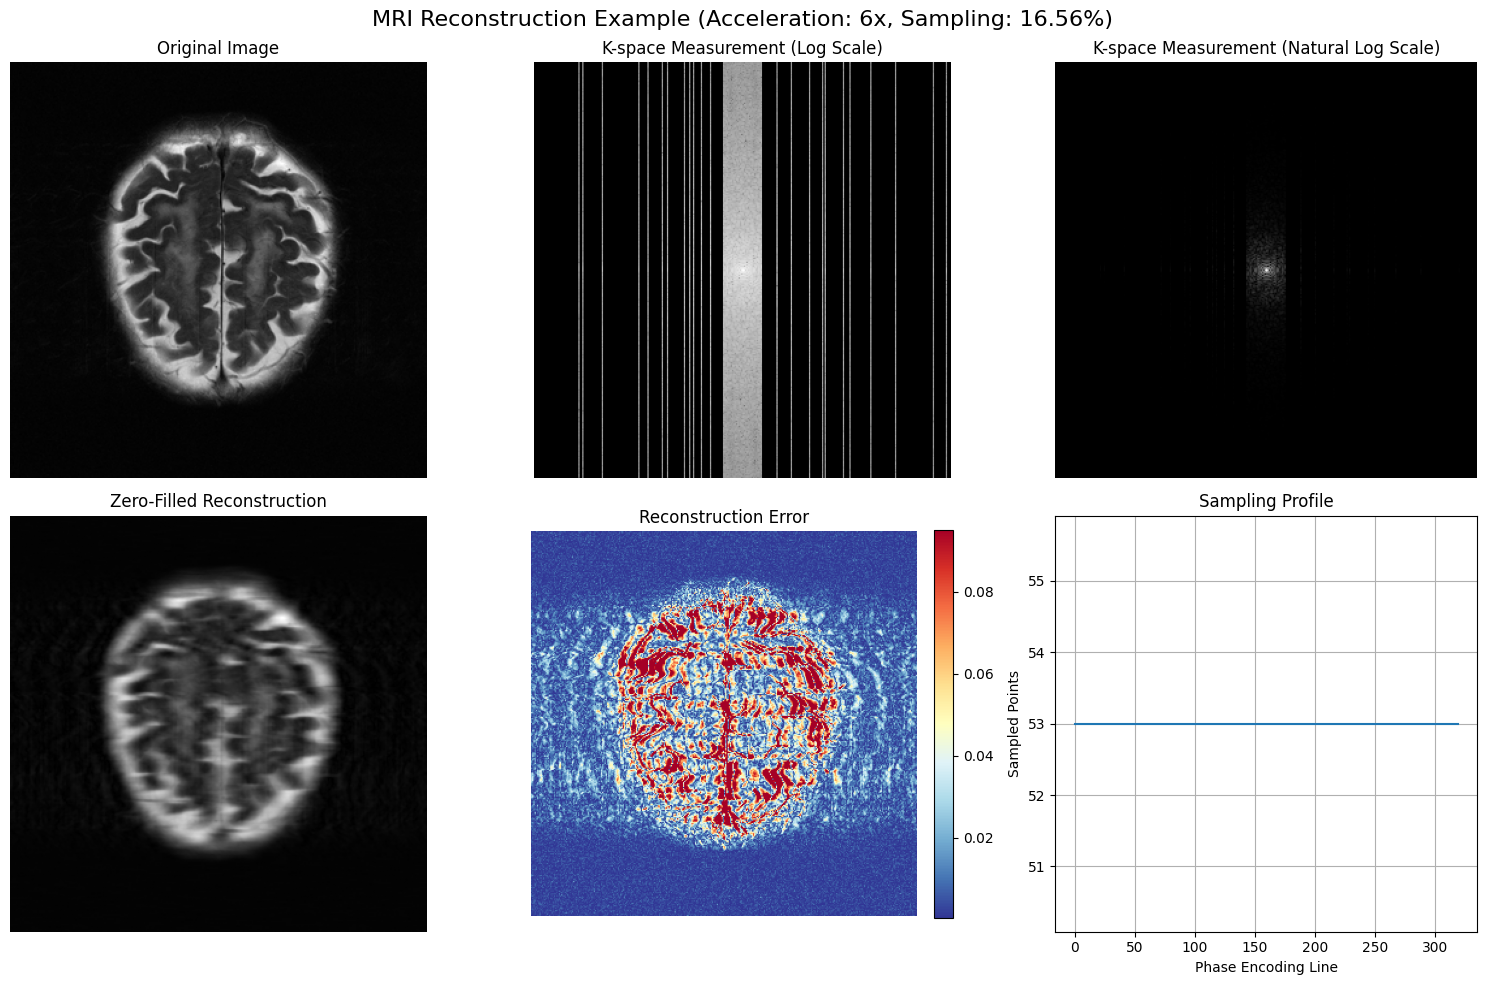

=== Reconstruction Statistics ===
Original image - Min: 0.0000, Max: 0.9686
Reconstructed image - Min: 0.0001, Max: 0.9644
Mean absolute error: 0.0215
Max absolute error: 0.4713
PSNR: 27.27 dB
Sampling ratio: 16.56%


In [14]:
def visualize_reconstruction(original_image, acc=4, batch_size=1, operator=MRIOperator, title="MRI Reconstruction", cmap='gray', save_path=None):
    """
    Visualize MRI reconstruction pipeline with original, k-space, and reconstructed images.
    
    Args:
        original_image: Input image tensor
        acc: Acceleration factor
        batch_size: Batch size for operator
        operator: MRIOperator class
        title: Plot title
        cmap: Colormap
        save_path: Path to save figure
    """
    operator = operator(acc=acc, device=original_image.device, batch_size=batch_size)
    
    measurement = operator.forward(original_image) # Forward operator to k-space (measurement)
    
    reconstructed = operator.transpose(measurement) # Zero-filled reconstruction

    # Convert to numpy for visualization
    if torch.is_tensor(original_image):
        original_np = original_image.detach().cpu().numpy().squeeze()
    
    if torch.is_tensor(measurement): 
        measurement_np = measurement.detach().cpu().numpy().squeeze()
        measurement_np = np.abs(measurement_np) if np.iscomplexobj(measurement_np) else measurement_np
    
    if torch.is_tensor(reconstructed):
        reconstructed_np = reconstructed.detach().cpu().numpy().squeeze()
        reconstructed_np = np.abs(reconstructed_np) if np.iscomplexobj(reconstructed_np) else reconstructed_np

    # Calculate difference
    difference = np.abs(original_np - reconstructed_np)
    
    # Calculate vmin/vmax for better contrast
    vmin = np.percentile(difference, 5)   # 5th percentile instead of min
    vmax = np.percentile(difference, 95)  # 95th percentile instead of max

    # Create subplot layout
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original Image 
    axes[0, 0].imshow(original_np, cmap=cmap)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    # K-space measurement (magnitude, log scale) 
    axes[0, 1].imshow(np.log(measurement_np + 1e-8), cmap=cmap)
    axes[0, 1].set_title("K-space Measurement (Log Scale)")
    axes[0, 1].axis('off')

    # K-space measurement (magnitude, natural log scale) 
    axes[0, 2].imshow(np.log1p(measurement_np + 1e-8), cmap='gray', aspect='auto')
    axes[0, 2].set_title("K-space Measurement (Natural Log Scale)")
    axes[0, 2].axis('off')

    # Zero-filled Reconstructed Image 
    axes[1, 0].imshow(reconstructed_np, cmap=cmap)
    axes[1, 0].set_title("Zero-Filled Reconstruction")
    axes[1, 0].axis('off')

    # Difference Image with improved colormap and scaling
    im_diff = axes[1, 1].imshow(difference, cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
    axes[1, 1].set_title("Reconstruction Error")
    axes[1, 1].axis('off')
    plt.colorbar(im_diff, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # Sampling profile (1D visualization of mask)
    mask_np = operator.mask.squeeze().detach().cpu().numpy() 
    profile = np.sum(mask_np, axis=1) if len(mask_np.shape) > 1 else mask_np
    axes[1, 2].plot(profile)
    axes[1, 2].set_title("Sampling Profile")
    axes[1, 2].set_xlabel("Phase Encoding Line")
    axes[1, 2].set_ylabel("Sampled Points")
    axes[1, 2].grid(True)

    # Calculate sampling ratio
    sampling_ratio = operator.mask.sum().item() / operator.mask.numel()
    
    fig.suptitle(f'{title} (Acceleration: {acc}x, Sampling: {sampling_ratio:.2%})', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved reconstruction visualization to {save_path}")
    
    plt.show()

    # Print statistics
    print(f"=== Reconstruction Statistics ===")
    print(f"Original image - Min: {original_np.min():.4f}, Max: {original_np.max():.4f}")
    print(f"Reconstructed image - Min: {reconstructed_np.min():.4f}, Max: {reconstructed_np.max():.4f}")
    print(f"Mean absolute error: {np.mean(difference):.4f}")
    print(f"Max absolute error: {np.max(difference):.4f}")
    print(f"PSNR: {20 * np.log10(np.max(original_np) / np.sqrt(np.mean(difference**2))):.2f} dB")
    print(f"Sampling ratio: {sampling_ratio:.2%}")
    
    return original_np, reconstructed_np, difference

recon = visualize_reconstruction(images[15], acc=6, batch_size=1, operator=MRIOperator, title="MRI Reconstruction Example", cmap='gray', save_path=None)

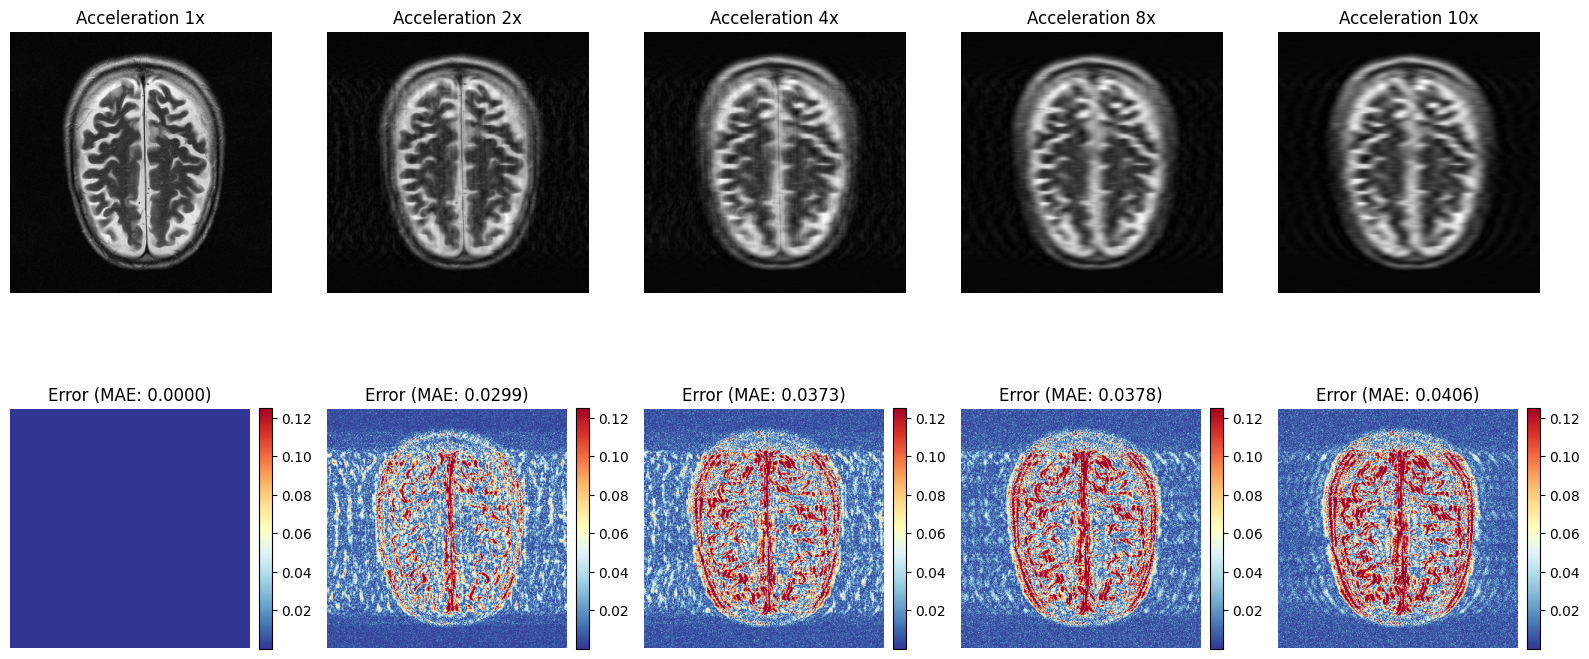

<Figure size 640x480 with 0 Axes>

In [15]:
def compare_acceleration_factors(image, device, acc_factors=[1, 2, 4, 8]):
    """
    Compare reconstruction quality at different acceleration factors.
    """
    fig, axes = plt.subplots(2, len(acc_factors), figsize=(16, 8))
    
    # Convert image to proper format if needed
    if len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension

    # Ensure image is on the correct device
    image = image.to(device)
    orig_np = image.detach().cpu().numpy().squeeze()

    # First pass: collect all error images to determine global vmin/vmax
    error_maps = []
    recon_maps = []
    for acc in acc_factors:
        operator = MRIOperator(acc=acc, device=device, batch_size=1)
        measurement = operator.forward(image)
        reconstructed = operator.transpose(measurement)
        recon_np = reconstructed.detach().cpu().numpy().squeeze()
        if np.iscomplexobj(recon_np):
            recon_np = np.abs(recon_np)
            recon_np = recon_np - recon_np.min()
            recon_np = recon_np / recon_np.max()
        diff = np.abs(orig_np - recon_np)
        error_maps.append(diff)
        recon_maps.append(recon_np)
    
    error_maps = np.array(error_maps)
    
    # Use percentile-based scaling for better contrast
    vmin = np.percentile(error_maps, 5)   # 5th percentile instead of min
    vmax = np.percentile(error_maps, 95)  # 95th percentile instead of max
    
    # Second pass: plot with consistent color scale
    for i, (acc, recon_np, diff) in enumerate(zip(acc_factors, recon_maps, error_maps)):
        axes[0, i].imshow(recon_np, cmap='gray')
        axes[0, i].set_title(f'Acceleration {acc}x')
        axes[0, i].axis('off')
        
        # Better colormap options for error visualization
        # im_diff = axes[1, i].imshow(diff, cmap='magma', vmin=vmin, vmax=vmax)  # Dark to bright yellow/white
        # Alternative options:
        # im_diff = axes[1, i].imshow(diff, cmap='inferno', vmin=vmin, vmax=vmax)  # Dark to bright red/yellow
        # im_diff = axes[1, i].imshow(diff, cmap='jet', vmin=vmin, vmax=vmax)     # Classic blue to red
        # im_diff = axes[1, i].imshow(diff, cmap='turbo', vmin=vmin, vmax=vmax)   # Modern rainbow
        im_diff = axes[1, i].imshow(diff, cmap='RdYlBu_r', vmin=vmin, vmax=vmax) # Red-Yellow-Blue reversed
        
        axes[1, i].set_title(f'Error (MAE: {np.mean(diff):.4f})')
        axes[1, i].axis('off')
        plt.colorbar(im_diff, ax=axes[1, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    plt.show()

compare_acceleration_factors(images[0], device=torch.device("cuda:3" if torch.cuda.is_available() else "cpu"), acc_factors=[1, 2, 4, 8, 10])

### iv. Saving Data for Acceleration 4x 

In [16]:
import torch

# Check available GPUs
print(f"Number of GPUs available: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")

# Use a specific GPU
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


Number of GPUs available: 4
GPU 0: NVIDIA RTX A6000
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
GPU 1: NVIDIA RTX A6000
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
GPU 2: NVIDIA RTX A6000
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB
GPU 3: NVIDIA RTX A6000
Memory allocated: 0.02 GB
Memory reserved: 0.03 GB


### FINAL WORKING DATALOADER/DATASET

In [17]:
from torch.utils.data import Dataset, DataLoader


In [18]:
"""DataLoader for MRI Images"""
class MRIDataset(Dataset):
    def __init__(self, images, acc=4):
        self.images = images
        self.acc = acc
        self.device = images.device
        self.operator = MRIOperator(acc=self.acc, device=self.device, batch_size=1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return {
            'image': image,
            "idx": idx
        }


class MRIDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=False):
        super(MRIDataLoader, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=self.collate_fn
        )
        
    def collate_fn(self, batch):
        images = torch.stack([item['image'] for item in batch])
        
        # MRI Operator
        operator = MRIOperator(acc=4, device=images.device, batch_size=images.shape[0])
        
        # Apply MRI forward operator to entire batch
        measurements = operator.forward(images)
        
        # Apply MRI transpose operator to get reconstructions
        reconstructions = operator.transpose(measurements)
        
        indices = [item['idx'] for item in batch]
        
        return {
            'images': images,
            'measurements': measurements,
            'reconstructions': reconstructions,
            'indices': indices
        }

In [19]:
def visualize_single_image(image, title="Single Image", cmap='gray', save_path=None):
    # Check if the image is a tensor and convert to numpy
    if torch.is_tensor(image):
        image = image.detach().cpu().numpy()
    
    # Remove channel dimension if exists
    if len(image.shape) == 4:
        image = image.squeeze(0).image.squeeze(0)
    elif len(image.shape) == 3:
        image = image.squeeze(0)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()

def visualize_single_measurement(measurement, title="Single K-space Measurement", cmap='gray', save_path=None):
    """
    Visualize a single k-space measurement.
    
    Args:
        measurement: K-space measurement tensor
        title: Plot title
        cmap: Colormap
        normalize: Whether to normalize the image
        save_path: Path to save figure
    """
    if torch.is_tensor(measurement):
        measurement = measurement.detach().cpu().numpy()
    
    if len(measurement.shape) == 4:
        measurement = measurement.squeeze(0).squeeze(0)
    elif len(measurement.shape) == 3:
        measurement = measurement.squeeze(0)

    measurement = np.abs(measurement) if np.iscomplexobj(measurement) else measurement
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    # K-space measurement (magnitude, log scale) 
    axes[0].imshow(np.log(measurement + 1e-8), cmap=cmap)
    axes[0].set_title("K-space Measurement (Log Scale)")
    axes[0].axis('off')

    # K-space measurement (magnitude, natural log scale) 
    axes[1].imshow(np.log1p(measurement + 1e-8), cmap='gray', aspect='equal')
    axes[1].set_title("K-space Measurement (Natural Log Scale)")
    axes[1].axis('off')

    fig.suptitle(title, fontsize=16)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()

def visualize_single_reconstructed(reconstructed, title="MRI Reconstruction", cmap='gray', save_path=None):
    if torch.is_tensor(reconstructed):
        reconstructed = reconstructed.detach().cpu().numpy()

    if len(reconstructed.shape) == 4:
        reconstructed = reconstructed.squeeze(0).squeeze(0)
    elif len(reconstructed.shape) == 3:
        reconstructed = reconstructed.squeeze(0)

    reconstructed = np.abs(reconstructed) if np.iscomplexobj(reconstructed) else reconstructed

    reconstructed = reconstructed - reconstructed.min()  # Normalize to [0, 1]
    reconstructed = reconstructed / reconstructed.max()

    plt.figure(figsize=(6, 6))
    plt.imshow(reconstructed, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    plt.show()


#### EXAMPLE USAGE

In [20]:
def load_img_to_tensor(source_dir, max_images=1000000, normalize=True, target_size=None, data_type = "tensor", device=None):
    png_images = glob.glob(os.path.join(source_dir, "**/*.png"), recursive=True) 
    
    images = []

    for file_name in tqdm(png_images[:max_images], desc="Loading images"):

        try:
            img = Image.open(file_name) 
            
            if target_size is not None: 
                img = img.resize(target_size, Image.LANCZOS)

            # Convert to numpy array 
            img_array = np.array(img)
            
            if normalize: 
                img_array = img_array.astype(np.float64) / 255.0
            else: 
                img_array = img_array.astype(np.float64)
                
            images.append(img_array) 
            
            if (len(images) >= max_images):
                break
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            continue
    
    if not images:
        raise ValueError("No images found in the specified directory.")
    
    if data_type == "tensor":
        images_numpy = np.array(images, dtype=np.float64)
        images_tensor = torch.from_numpy(images_numpy).float().to(device)

        if len(images_tensor.shape) == 3:
            images_tensor = images_tensor.unsqueeze(1)
            
        return images_tensor
    elif data_type == "numpy":
        images_numpy = np.array(images, dtype=np.float64)
        return images_numpy

Loading all images into memory...


Loading images: 100%|█████████▉| 999/1000 [00:00<00:00, 1106.41it/s]


Creating dataset and dataloader...
Dataset size: 1000
Number of batches: 63
Testing dataloader...
Length of dataset: 1000
Batch 0:
  Images shape: torch.Size([16, 1, 320, 320])
  Measurements shape: torch.Size([16, 1, 320, 320])
  Reconstructions shape: torch.Size([16, 1, 320, 320])
  Device: cuda:3


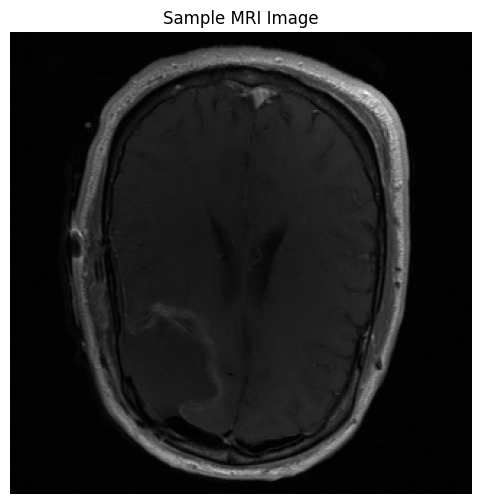

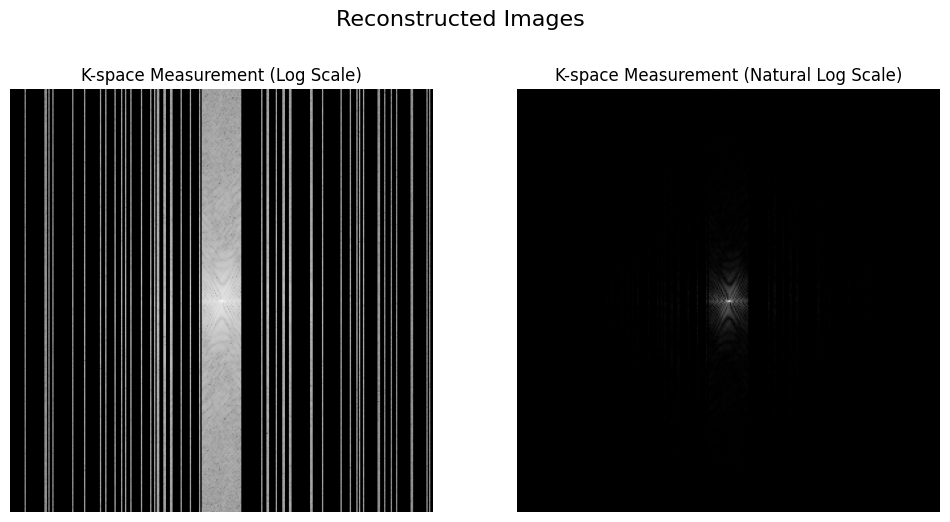

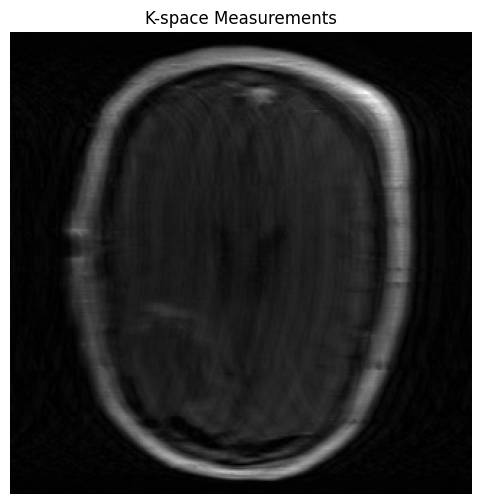

Batch 1:
  Images shape: torch.Size([16, 1, 320, 320])
  Measurements shape: torch.Size([16, 1, 320, 320])
  Reconstructions shape: torch.Size([16, 1, 320, 320])
  Device: cuda:3
Batch 2:
  Images shape: torch.Size([16, 1, 320, 320])
  Measurements shape: torch.Size([16, 1, 320, 320])
  Reconstructions shape: torch.Size([16, 1, 320, 320])
  Device: cuda:3
Dataloader test completed successfully!


In [21]:

if __name__ == "__main__":
    # Step 1: Load all images into memory
    source_dir = MRI_DIR
    max_images = 1000  # Adjust based on your memory
    target_size = (320, 320)
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    
    print("Loading all images into memory...")
    all_images = load_img_to_tensor(
        source_dir=source_dir,
        max_images=max_images,
        normalize=True,
        target_size=target_size,
        device=device
    )
    
    # Step 2: Create dataset and dataloader
    print("Creating dataset and dataloader...")
    mri_dataset = MRIDataset(all_images, acc=4)
    
    mri_dataloader = MRIDataLoader(
        mri_dataset,
        batch_size=16,
        shuffle=True
    )
    
    print(f"Dataset size: {len(mri_dataset)}")
    print(f"Number of batches: {len(mri_dataloader)}")
    
    # Step 3: Test the dataloader
    print("Testing dataloader...")
    print("Length of dataset:", len(mri_dataset))
    for batch_idx, batch in enumerate(mri_dataloader):
        images = batch['images']
        measurements = batch['measurements']
        reconstructions = batch['reconstructions']
        
        print(f"Batch {batch_idx}:")
        print(f"  Images shape: {images.shape}")
        print(f"  Measurements shape: {measurements.shape}")
        print(f"  Reconstructions shape: {reconstructions.shape}")
        print(f"  Device: {images.device}")
        
        # Visualize first image in first batch
        if batch_idx == 0:
            visualize_single_image(images[0], title="Sample MRI Image", cmap='gray')
            visualize_single_measurement(measurements[0], title="Reconstructed Images")
            visualize_single_reconstructed(reconstructions[0], title="K-space Measurements")
        
        if batch_idx >= 2:  # Test only first few batches
            break
    
    print("Dataloader test completed successfully!")

## GRAPPA reconstruction

In [22]:
class GRAPPAOperator(LinearOperator):
    """
    GRAPPAOperator performs multi-coil forward simulation and GRAPPA reconstruction.
    """
    def __init__(self, acc, device, num_coils=8, acs_lines=32, kernel_size=(3, 3), batch_size=1):
        super(GRAPPAOperator, self).__init__()
        self.acc = acc
        self.device = device
        self.num_coils = num_coils
        self.acs_lines = acs_lines
        self.kernel_size = kernel_size
        self.mask = get_mask(batch_size=batch_size, R=self.acc, acs_lines=self.acs_lines).to(device)

    def create_synthetic_csms(self, h, w):
        csms = torch.zeros((self.num_coils, h, w), device=self.device, dtype=torch.complex64)
        for i in range(self.num_coils):
            x_phase = torch.linspace(-np.pi, np.pi, w, device=self.device) * (i - self.num_coils / 2)
            y_phase = torch.linspace(-np.pi, np.pi, h, device=self.device) * (i - self.num_coils / 2)
            y_grid, x_grid = torch.meshgrid(y_phase, x_phase, indexing='ij')
            csms[i, :, :] = torch.exp(1j * (x_grid + y_grid))
        return csms

    def forward(self, data, **kwargs):
        if data.dim() == 3:
            data = data.unsqueeze(0)
        if data.shape[1] == 1:
            data = data.squeeze(1)

        batch_size, height, width = data.shape
        csms = self.create_synthetic_csms(height, width)
        full_k_space = torch.zeros(
            (batch_size, self.num_coils, height, width),
            device=self.device,
            dtype=torch.complex64
        )
        for i in range(batch_size):
            img_complex = torch.complex(data[i], torch.zeros_like(data[i]))
            for c in range(self.num_coils):
                coil_img = img_complex * csms[c]
                full_k_space[i, c, :, :] = fft2_m(coil_img)

        mask_expanded = self.mask.unsqueeze(1).unsqueeze(-1).expand(-1, self.num_coils, -1, width)
        undersampled_kspace = full_k_space * mask_expanded
        return undersampled_kspace

    def transpose(self, undersampled_kspace, **kwargs):
        batch_size, num_coils, height, width = undersampled_kspace.shape
        kh, kw = self.kernel_size

        # 1) Initialize reconstructed_kspace with the undersampled data
        reconstructed_kspace = undersampled_kspace.clone()

        # 2) Extract the ACS region (centered in ky)
        center_h = height // 2
        acs_start = center_h - self.acs_lines // 2
        acs_end = center_h + self.acs_lines // 2
        acs_region = undersampled_kspace[:, :, acs_start:acs_end, :]  # (B, C, num_acs_lines, W)
        num_acs_lines, acs_width = acs_region.shape[2], acs_region.shape[3]

        # 3) Build source/target matrices from ACS
        source_patches = []
        target_patches = []
        for y_acs in range(num_acs_lines - (kh - 1) * self.acc):
            for x_acs in range(acs_width - kw):
                # (a) Source patch: size (B, num_coils, kh, kw)
                src = torch.zeros((batch_size, num_coils, kh, kw),
                                  device=self.device, dtype=torch.complex64)
                for i in range(kh):
                    ky_index = y_acs + i * self.acc
                    src[:, :, i, :] = acs_region[:, :, ky_index, x_acs : x_acs + kw]

                source_patches.append(src.reshape(batch_size, -1))

                # (b) Target: center of the (kh×kw) window
                ky_center = y_acs + (kh // 2) * self.acc
                kx_center = x_acs + (kw // 2)
                tgt = acs_region[:, :, ky_center, kx_center]  # (B, num_coils)
                target_patches.append(tgt)

        Source = torch.stack(source_patches, dim=1)  # (B, #patches, features)
        Target = torch.stack(target_patches, dim=1)  # (B, #patches, num_coils)

        # 4) Solve for W using normal equations + Tikhonov regularization
        S_H = Source.permute(0, 2, 1).conj()                   # (B, features, #patches)
        SHS = torch.matmul(S_H, Source)                        # (B, features, features)
        SHT = torch.matmul(S_H, Target)                        # (B, features, num_coils)

        λ = 1e-3  # small regularization constant
        I = torch.eye(SHS.shape[-1], device=SHS.device).unsqueeze(0)  # (1, features, features)
        W = torch.linalg.solve(SHS + λ * I, SHT)                # (B, features, num_coils)

        # 5) Reconstruct missing k-space lines
        y_min = (kh // 2) * self.acc
        y_max = height - (kh // 2) * self.acc
        for y in range(y_min, y_max):
            # Check a single column to see if that entire ky row was acquired
            if self.mask[0, y] == 1:
                continue  # fully sampled row, no need to interpolate

            for x in range(kw // 2, width - (kw // 2)):
                # Build source patch around (y, x)
                src_patch = torch.zeros((batch_size, num_coils, kh, kw),
                                        device=self.device, dtype=torch.complex64)
                for i in range(kh):
                    ky_i = y + (i - kh // 2) * self.acc
                    src_patch[:, :, i, :] = reconstructed_kspace[:, :, ky_i,
                                                   x - (kw // 2) : x + (kw // 2) + 1]

                src_vec = src_patch.reshape(batch_size, 1, -1)  # (B, 1, features)
                rec_pt = torch.matmul(src_vec, W)               # (B, 1, num_coils)
                reconstructed_kspace[:, :, y, x] = rec_pt.squeeze(1)

        # 6) Inverse FFT + root-sum-of-squares coil combine
        reconstructed_images = torch.zeros((batch_size, height, width),
                                           device=self.device, dtype=torch.float32)
        for i in range(batch_size):
            coil_images = ifft2_m(reconstructed_kspace[i])  # (num_coils, H, W)
            rss = torch.sqrt(torch.sum(torch.abs(coil_images) ** 2, dim=0))  # (H, W)
            reconstructed_images[i] = rss

        # 7) Add channel dimension back → (B, 1, H, W)
        return reconstructed_images.unsqueeze(1)

In [23]:
### Example usage 
# --- 1. Standard Data Loading ---
source_dir = MRI_DIR 
max_images = 100
target_size = (320, 320)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

images = load_img_to_tensor(source_dir, max_images=max_images, target_size=target_size, data_type="tensor", device=device)
print(f"Loaded {len(images)} images of shape {images.shape} to device: {device}")


Loading images:  99%|█████████▉| 99/100 [00:00<00:00, 1223.76it/s]

Loaded 100 images of shape torch.Size([100, 1, 320, 320]) to device: cuda:3


Undersampled multi-coil k-space shape: torch.Size([1, 4, 320, 320])
GRAPPA reconstructed image shape: torch.Size([1, 1, 320, 320])


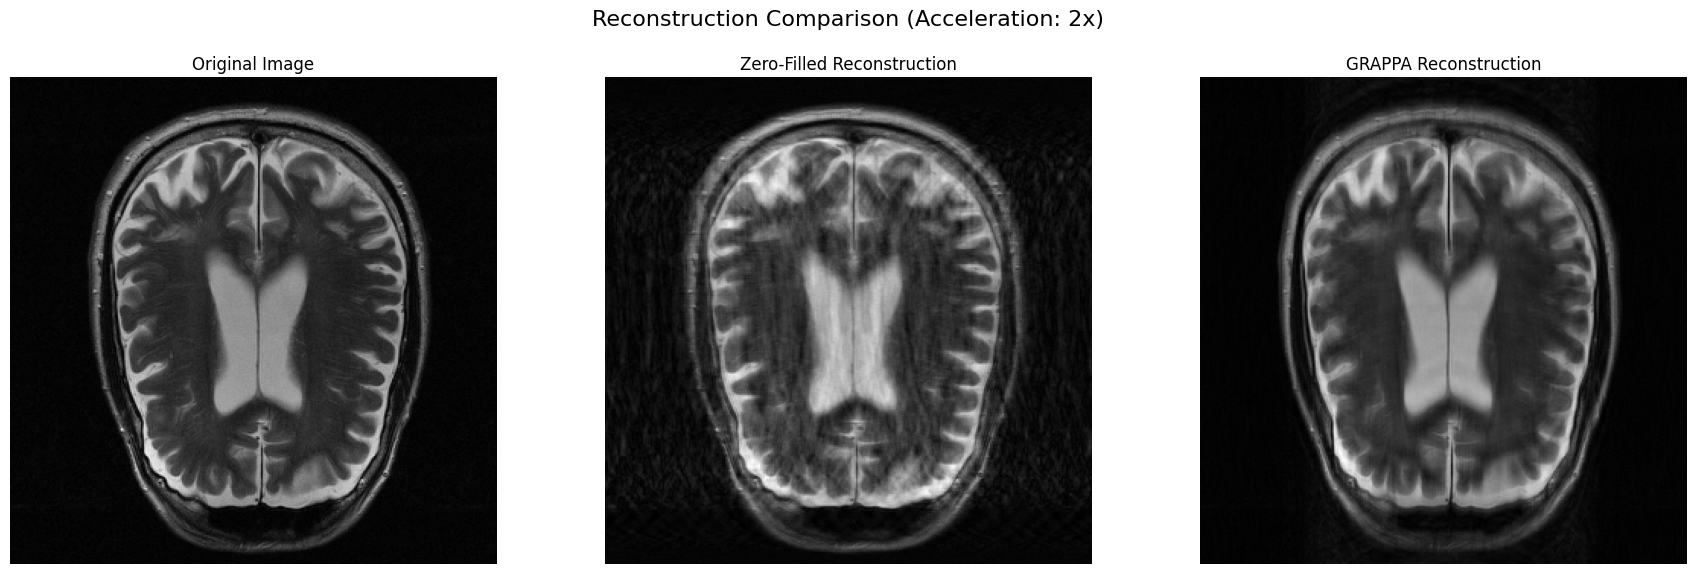

In [24]:

# --- 2. Setup Operators ---
acc = 2 # Acceleration factor
sample_image = images[14].unsqueeze(0) # Use one sample for demonstration, add batch dim

# a) Your original Zero-Filling Operator
zero_fill_operator = MRIOperator(acc=acc, device=device, batch_size=1)

# b) The new GRAPPA Operator
grappa_operator = GRAPPAOperator(acc=acc, device=device, num_coils=4)

# --- 3. Perform Forward and Reconstruction Steps ---

# a) Zero-Filled Reconstruction
undersampled_single_coil = zero_fill_operator.forward(sample_image)
zero_filled_recon = zero_fill_operator.transpose(undersampled_single_coil)

# b) GRAPPA Reconstruction
undersampled_multi_coil = grappa_operator.forward(sample_image)
grappa_recon = grappa_operator.transpose(undersampled_multi_coil)

print(f"Undersampled multi-coil k-space shape: {undersampled_multi_coil.shape}")
print(f"GRAPPA reconstructed image shape: {grappa_recon.shape}")

# --- 4. Visualize the Comparison ---
orig_np = sample_image.detach().cpu().numpy().squeeze()
zf_np = np.abs(zero_filled_recon.detach().cpu().numpy().squeeze())
grappa_np = grappa_recon.detach().cpu().numpy().squeeze()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Reconstruction Comparison (Acceleration: {acc}x)', fontsize=16)

axes[0].imshow(orig_np, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(zf_np, cmap='gray')
axes[1].set_title("Zero-Filled Reconstruction")
axes[1].axis('off')

axes[2].imshow(grappa_np, cmap='gray')
axes[2].set_title("GRAPPA Reconstruction")
axes[2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Example of how to integrate into your DataLoader
# You would modify the collate_fn to use the GRAPPAOperator
# class MRIDataLoader(DataLoader):
#     def collate_fn(self, batch):
#         images = torch.stack([item['image'] for item in batch])
#         
#         # Use GRAPPAOperator here
#         operator = GRAPPAOperator(acc=4, device=images.device, num_coils=8)
#         
#         measurements = operator.forward(images)
#         reconstructions = operator.transpose(measurements) # This is now the GRAPPA recon
#         
#         indices = [item['idx'] for item in batch]
#         
#         return {
#             'images': images,
#             'measurements': measurements,
#             'reconstructions': reconstructions,
#             'indices': indices
#         }

In [25]:
def visualize_operators_reconstruction(original_image, device, acc=4, batch_size=1, num_coils=8, acs_lines=32, kernel_size=(3, 3), operator=GRAPPAOperator, title="MRI vs GRAPPA Reconstruction", cmap='gray', save_path=None):
    """
    Visualize MRI reconstruction pipeline comparing MRI and GRAPPA operators.
    
    Args:
        original_image: Input image tensor
        acc: Acceleration factor
        batch_size: Batch size for operator
        operator: MRIOperator class
        title: Plot title
        cmap: Colormap
        save_path: Path to save figure
    """
    mri_operator = MRIOperator(acc=acc, device=device, batch_size=batch_size)
    grappa_operator = GRAPPAOperator(acc=acc, device=device, num_coils=num_coils, acs_lines=acs_lines, kernel_size=kernel_size)

    original_image = original_image.to(device)

    # Apply operators
    mri_measurement = mri_operator.forward(original_image)
    mri_reconstruction = mri_operator.transpose(mri_measurement)
    grappa_measurement = grappa_operator.forward(original_image)
    grappa_reconstruction = grappa_operator.transpose(grappa_measurement)

    # Convert to numpy for visualization
    original = original_image.detach().cpu().numpy().squeeze()
    
    mri_measurement = mri_measurement.detach().cpu().numpy().squeeze()
    mri_measurement = np.abs(mri_measurement) if np.iscomplexobj(mri_measurement) else mri_measurement
    
    mri_reconstruction = mri_reconstruction.detach().cpu().numpy().squeeze()
    mri_reconstruction = np.abs(mri_reconstruction) if np.iscomplexobj(mri_reconstruction) else mri_reconstruction
    
    grappa_measurement = grappa_measurement.detach().cpu().numpy().squeeze()
    grappa_measurement = np.abs(grappa_measurement) if np.iscomplexobj(grappa_measurement) else grappa_measurement
    # For multi-coil data, take RSS across coils
    if len(grappa_measurement.shape) == 3:
        grappa_measurement = np.sqrt(np.sum(grappa_measurement**2, axis=0))
    
    grappa_reconstruction = grappa_reconstruction.detach().cpu().numpy().squeeze()
    grappa_reconstruction = np.abs(grappa_reconstruction) if np.iscomplexobj(grappa_reconstruction) else grappa_reconstruction

    # Calculate errors
    difference_mri = np.abs(original - mri_reconstruction)
    difference_grappa = np.abs(original - grappa_reconstruction)
    
    # Global error bounds for consistent comparison
    all_errors = np.concatenate([difference_mri.flatten(), difference_grappa.flatten()])
    vmin_global = np.percentile(all_errors, 5)
    vmax_global = np.percentile(all_errors, 95)

    # Create figure with better spacing
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.patch.set_facecolor('white')
    
    # Calculate sampling ratio
    sampling_ratio = grappa_operator.mask.sum().item() / grappa_operator.mask.numel()
    
    # Main title with statistics
    fig.suptitle(f'{title}\nAcceleration: {acc}x | Sampling: {sampling_ratio:.1%} | MAE (MRI): {np.mean(difference_mri):.4f} | MAE (GRAPPA): {np.mean(difference_grappa):.4f}', 
                 fontsize=16, fontweight='bold', y=0.95)

    # Row 1: MRI Operator
    row_title_props = dict(fontsize=14, fontweight='bold', color='darkblue')
    
    # Original Image (shared)
    axes[0, 0].imshow(original, cmap=cmap)
    axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # MRI K-space
    axes[0, 1].imshow(np.log(mri_measurement + 1e-8), cmap='viridis', aspect='equal')
    axes[0, 1].set_title("MRI K-space\n(Log Scale)", fontsize=12)
    axes[0, 1].axis('off')
    
    # MRI Reconstruction
    axes[0, 2].imshow(mri_reconstruction, cmap=cmap)
    axes[0, 2].set_title("MRI Zero-Filled\nReconstruction", fontsize=12)
    axes[0, 2].axis('off')
    
    # MRI Error
    im_diff_mri = axes[0, 3].imshow(difference_mri, cmap='RdYlBu_r', vmin=vmin_global, vmax=vmax_global)
    axes[0, 3].set_title("MRI Reconstruction\nError", fontsize=12)
    axes[0, 3].axis('off')
    
    # Add colorbar for MRI error
    cbar_mri = plt.colorbar(im_diff_mri, ax=axes[0, 3], fraction=0.046, pad=0.04)
    cbar_mri.set_label('Error Magnitude', fontsize=10)

    # Row 2: GRAPPA Operator
    # Original Image (shared)
    axes[1, 0].imshow(original, cmap=cmap)
    axes[1, 0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # GRAPPA K-space
    axes[1, 1].imshow(np.log(grappa_measurement + 1e-8), cmap='viridis', aspect='equal')
    axes[1, 1].set_title("GRAPPA K-space\n(RSS Combined, Log Scale)", fontsize=12)
    axes[1, 1].axis('off')
    
    # GRAPPA Reconstruction
    axes[1, 2].imshow(grappa_reconstruction, cmap=cmap)
    axes[1, 2].set_title("GRAPPA\nReconstruction", fontsize=12)
    axes[1, 2].axis('off')
    
    # GRAPPA Error
    im_diff_grappa = axes[1, 3].imshow(difference_grappa, cmap='RdYlBu_r', vmin=vmin_global, vmax=vmax_global)
    axes[1, 3].set_title("GRAPPA Reconstruction\nError", fontsize=12)
    axes[1, 3].axis('off')
    
    # Add colorbar for GRAPPA error
    cbar_grappa = plt.colorbar(im_diff_grappa, ax=axes[1, 3], fraction=0.046, pad=0.04)
    cbar_grappa.set_label('Error Magnitude', fontsize=10)

    # Add method labels on the left
    fig.text(0.02, 0.75, 'MRI Operator', rotation=90, fontsize=14, fontweight='bold', 
             color='darkblue', ha='center', va='center')
    fig.text(0.02, 0.25, 'GRAPPA Operator', rotation=90, fontsize=14, fontweight='bold', 
             color='darkred', ha='center', va='center')

    # Adjust layout
    plt.subplots_adjust(left=0.05, right=0.95, top=0.87, bottom=0.05, hspace=0.3, wspace=0.15)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved reconstruction visualization to {save_path}")
    
    plt.show()
    
    # Print detailed statistics
    print(f"\n{'='*60}")
    print(f"RECONSTRUCTION COMPARISON STATISTICS")
    print(f"{'='*60}")
    print(f"Acceleration Factor: {acc}x")
    print(f"Sampling Ratio: {sampling_ratio:.2%}")
    print(f"\nMRI Operator (Zero-Filled):")
    print(f"  - Mean Absolute Error: {np.mean(difference_mri):.6f}")
    print(f"  - Max Absolute Error:  {np.max(difference_mri):.6f}")
    print(f"  - PSNR: {20 * np.log10(np.max(original) / np.sqrt(np.mean(difference_mri**2))):.2f} dB")
    print(f"\nGRAPPA Operator:")
    print(f"  - Mean Absolute Error: {np.mean(difference_grappa):.6f}")
    print(f"  - Max Absolute Error:  {np.max(difference_grappa):.6f}")
    print(f"  - PSNR: {20 * np.log10(np.max(original) / np.sqrt(np.mean(difference_grappa**2))):.2f} dB")
    print(f"\nImprovement (GRAPPA vs MRI):")
    mae_improvement = ((np.mean(difference_mri) - np.mean(difference_grappa)) / np.mean(difference_mri)) * 100
    print(f"  - MAE Reduction: {mae_improvement:.1f}%")
    print(f"{'='*60}")

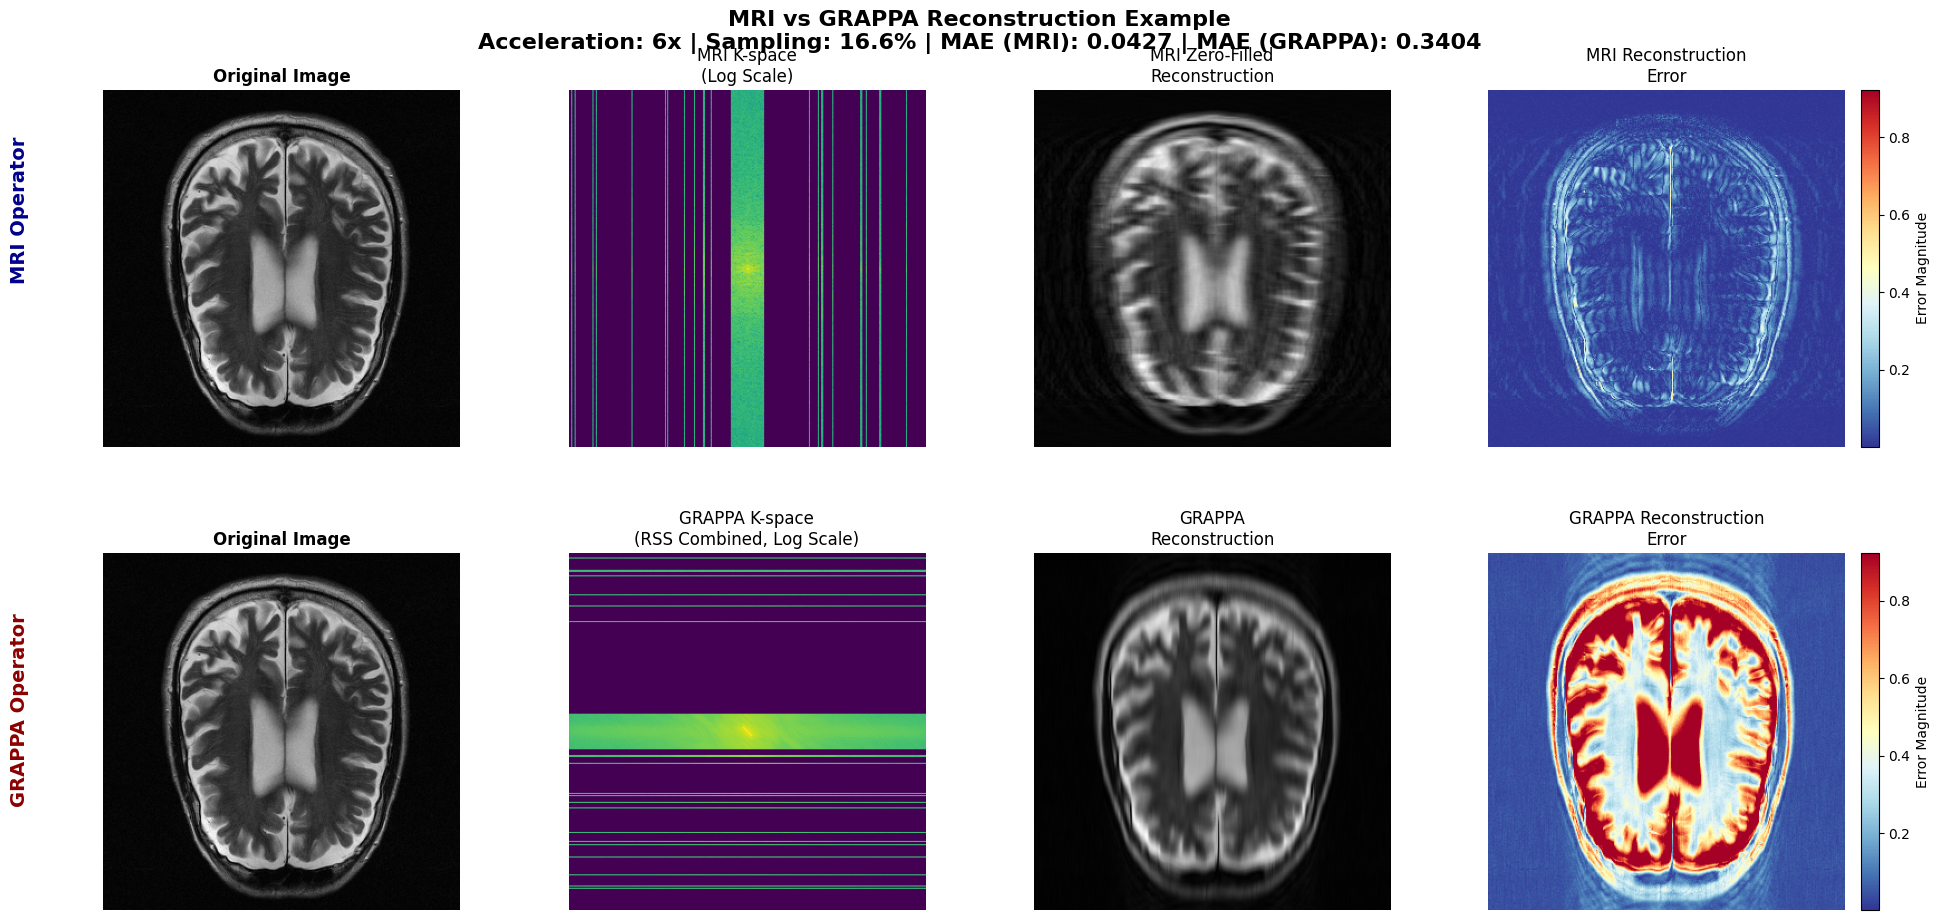


RECONSTRUCTION COMPARISON STATISTICS
Acceleration Factor: 6x
Sampling Ratio: 16.56%

MRI Operator (Zero-Filled):
  - Mean Absolute Error: 0.042686
  - Max Absolute Error:  0.588370
  - PSNR: 22.75 dB

GRAPPA Operator:
  - Mean Absolute Error: 0.340358
  - Max Absolute Error:  1.896794
  - PSNR: 6.07 dB

Improvement (GRAPPA vs MRI):
  - MAE Reduction: -697.4%


In [26]:
visualize_operators_reconstruction(images[15], device=device, acc=6, batch_size=1, operator=MRIOperator, title="MRI vs GRAPPA Reconstruction Example", cmap='gray', save_path=None)

### NumPy GRAPPAOperator implementation 

In [27]:
import numpy as np
from scipy.linalg import solve

class GRAPPAOperator_np(LinearOperator):
    """
    GRAPPAOperator performs multi-coil forward simulation and GRAPPA reconstruction using NumPy.
    """
    def __init__(self, acc, num_coils=8, acs_lines=32, kernel_size=(3, 3), batch_size=1):
        super(GRAPPAOperator_np, self).__init__()
        self.acc = acc
        self.num_coils = num_coils
        self.acs_lines = acs_lines
        self.kernel_size = kernel_size
        self.mask = get_mask_np(batch_size=batch_size, R=self.acc, acs_lines=self.acs_lines)

    def create_synthetic_csms(self, h, w):
        csms = np.zeros((self.num_coils, h, w), dtype=np.complex64)
        for i in range(self.num_coils):
            x_phase = np.linspace(-np.pi, np.pi, w) * (i - self.num_coils / 2)
            y_phase = np.linspace(-np.pi, np.pi, h) * (i - self.num_coils / 2)
            y_grid, x_grid = np.meshgrid(y_phase, x_phase, indexing='ij')
            csms[i, :, :] = np.exp(1j * (x_grid + y_grid))
        return csms

    def forward(self, data, **kwargs):
        # Convert torch tensor to numpy if needed
        if hasattr(data, 'detach'):
            data = data.detach().cpu().numpy()
        
        if data.ndim == 3:
            data = np.expand_dims(data, axis=0)
        if data.shape[1] == 1:
            data = np.squeeze(data, axis=1)

        batch_size, height, width = data.shape
        csms = self.create_synthetic_csms(height, width)
        full_k_space = np.zeros(
            (batch_size, self.num_coils, height, width),
            dtype=np.complex64
        )
        
        for i in range(batch_size):
            img_complex = data[i].astype(np.complex64)
            for c in range(self.num_coils):
                coil_img = img_complex * csms[c]
                full_k_space[i, c, :, :] = fft2_m_np(coil_img)

        # Expand mask for broadcasting
        mask_expanded = np.expand_dims(self.mask, axis=1)  # (B, 1, H)
        mask_expanded = np.expand_dims(mask_expanded, axis=-1)  # (B, 1, H, 1)
        mask_expanded = np.broadcast_to(mask_expanded, (batch_size, self.num_coils, height, width))
        
        undersampled_kspace = full_k_space * mask_expanded
        return undersampled_kspace

    def transpose(self, undersampled_kspace, **kwargs):
        # Convert torch tensor to numpy if needed
        if hasattr(undersampled_kspace, 'detach'):
            undersampled_kspace = undersampled_kspace.detach().cpu().numpy()
            
        batch_size, num_coils, height, width = undersampled_kspace.shape
        kh, kw = self.kernel_size

        # 1) Initialize reconstructed_kspace with the undersampled data
        reconstructed_kspace = undersampled_kspace.copy()

        # 2) Extract the ACS region (centered in ky)
        center_h = height // 2
        acs_start = center_h - self.acs_lines // 2
        acs_end = center_h + self.acs_lines // 2
        acs_region = undersampled_kspace[:, :, acs_start:acs_end, :]  # (B, C, num_acs_lines, W)
        num_acs_lines, acs_width = acs_region.shape[2], acs_region.shape[3]

        # 3) Build source/target matrices from ACS
        source_patches = []
        target_patches = []
        for y_acs in range(num_acs_lines - (kh - 1) * self.acc):
            for x_acs in range(acs_width - kw):
                # (a) Source patch: size (B, num_coils, kh, kw)
                src = np.zeros((batch_size, num_coils, kh, kw), dtype=np.complex64)
                for i in range(kh):
                    ky_index = y_acs + i * self.acc
                    src[:, :, i, :] = acs_region[:, :, ky_index, x_acs:x_acs + kw]

                source_patches.append(src.reshape(batch_size, -1))

                # (b) Target: center of the (kh×kw) window
                ky_center = y_acs + (kh // 2) * self.acc
                kx_center = x_acs + (kw // 2)
                tgt = acs_region[:, :, ky_center, kx_center]  # (B, num_coils)
                target_patches.append(tgt)

        Source = np.stack(source_patches, axis=1)  # (B, #patches, features)
        Target = np.stack(target_patches, axis=1)  # (B, #patches, num_coils)

        # 4) Solve for W using normal equations + Tikhonov regularization
        S_H = np.conj(np.transpose(Source, (0, 2, 1)))  # (B, features, #patches)
        SHS = np.matmul(S_H, Source)  # (B, features, features)
        SHT = np.matmul(S_H, Target)  # (B, features, num_coils)

        λ = 1e-3  # small regularization constant
        I = np.expand_dims(np.eye(SHS.shape[-1]), axis=0)  # (1, features, features)
        I = np.broadcast_to(I, SHS.shape)  # (B, features, features)
        
        # Solve for each batch
        W = np.zeros_like(SHT)
        for b in range(batch_size):
            W[b] = solve(SHS[b] + λ * I[b], SHT[b])

        # 5) Reconstruct missing k-space lines
        y_min = (kh // 2) * self.acc
        y_max = height - (kh // 2) * self.acc
        for y in range(y_min, y_max):
            # Check a single column to see if that entire ky row was acquired
            if self.mask[0, y] == 1:
                continue  # fully sampled row, no need to interpolate

            for x in range(kw // 2, width - (kw // 2)):
                # Build source patch around (y, x)
                src_patch = np.zeros((batch_size, num_coils, kh, kw), dtype=np.complex64)
                for i in range(kh):
                    ky_i = y + (i - kh // 2) * self.acc
                    src_patch[:, :, i, :] = reconstructed_kspace[:, :, ky_i, 
                                                               x - (kw // 2):x + (kw // 2) + 1]

                src_vec = src_patch.reshape(batch_size, 1, -1)  # (B, 1, features)
                rec_pt = np.matmul(src_vec, W)  # (B, 1, num_coils)
                reconstructed_kspace[:, :, y, x] = np.squeeze(rec_pt, axis=1)

        # 6) Inverse FFT + root-sum-of-squares coil combine
        reconstructed_images = np.zeros((batch_size, height, width), dtype=np.float32)
        for i in range(batch_size):
            coil_images = ifft2_m_np(reconstructed_kspace[i])  # (num_coils, H, W)
            rss = np.sqrt(np.sum(np.abs(coil_images) ** 2, axis=0))  # (H, W)
            reconstructed_images[i] = rss

        # 7) Add channel dimension back → (B, 1, H, W)
        return np.expand_dims(reconstructed_images, axis=1)


def shufflerow_np(tensor, axis):
    """NumPy version of shufflerow function"""
    # Get the shape for the permutation
    perm_shape = tensor.shape[:axis+1]
    row_perm = np.random.rand(*perm_shape).argsort(axis)
    
    # Expand dimensions to match original tensor
    for _ in range(tensor.ndim - axis - 1):
        row_perm = np.expand_dims(row_perm, axis=-1)
    
    # Broadcast to full tensor shape
    row_perm = np.broadcast_to(row_perm, tensor.shape)
    
    # Use advanced indexing instead of gather
    return np.take_along_axis(tensor, row_perm, axis=axis)


def get_mask_np(batch_size=1, acs_lines=32, total_lines=320, R=1):
    """NumPy version of get_mask function"""
    # Overall sampling budget
    num_sampled_lines = total_lines // R

    # Get locations of ACS lines
    center_line_idx = np.arange((total_lines - acs_lines) // 2,
                               (total_lines + acs_lines) // 2)

    # Find remaining candidates
    outer_line_idx = np.concatenate([
        np.arange(0, (total_lines - acs_lines) // 2),
        np.arange((total_lines + acs_lines) // 2, total_lines)
    ])
    
    # Repeat for batch size and shuffle
    outer_expanded = np.tile(outer_line_idx, (batch_size, 1))
    random_line_idx = shufflerow_np(outer_expanded, 1)[:, :num_sampled_lines - acs_lines]

    # Create a mask and place ones at the right locations
    mask = np.zeros((batch_size, total_lines))
    mask[:, center_line_idx] = 1.0
    
    # Set random lines to 1
    batch_indices = np.arange(batch_size).repeat(random_line_idx.shape[-1])
    line_indices = random_line_idx.reshape(-1)
    mask[batch_indices, line_indices] = 1.0

    return mask


# Helper functions for FFT operations (NumPy versions)
def fft2_m_np(data):
    """2D FFT using NumPy"""
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(data)))

def ifft2_m_np(data):
    """2D IFFT using NumPy"""
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data)))

In [28]:
import numpy as np
import torch
from PIL import Image

def to_uint8(image) -> np.ndarray:
    if torch.is_tensor(image):
        image = image.detach().cpu().numpy()

    if np.iscomplexobj(image):
        image = np.abs(image)

    image = image - image.min()               # shift to 0
    maxv  = image.max()
    if maxv > 0:
        image = image / maxv                  # scale to 0-1

    return (image * 255).astype(np.uint8)


def write_png(img, out_path: str):
    Image.fromarray(to_uint8(img), mode="L").save(out_path)

# Save images 

In [29]:
### Example usage 
# --- 1. Standard Data Loading ---
source_dir = MRI_DIR 
max_images = 12000
target_size = (320, 320)
device = "cuda:3"
images = load_img_to_tensor(source_dir, max_images=max_images, target_size=target_size, data_type="tensor", device=device)
print(f"Loaded {len(images)} images of shape {images.shape} to device: {device}")


Loading images: 100%|█████████▉| 11999/12000 [00:10<00:00, 1134.32it/s]


Loaded 12000 images of shape torch.Size([12000, 1, 320, 320]) to device: cuda:3


In [30]:
grappa_dir_2 = "./data/12000_img/GRAPPA_acc2/"
grappa_dir_4 = "./data/12000_img/GRAPPA_acc4/"
grappa_dir_6 = "./data/12000_img/GRAPPA_acc6/"
grappa_dir_8 = "./data/12000_img/GRAPPA_acc8/"

clean_dir = "./data/12000_img/Clean/"
grappa_operator_2 = GRAPPAOperator_np(acc=2, num_coils=8, acs_lines=32, kernel_size=(3, 3), batch_size=1)
grappa_operator_4 = GRAPPAOperator_np(acc=4, num_coils=8, acs_lines=32, kernel_size=(3, 3), batch_size=1)
grappa_operator_6 = GRAPPAOperator_np(acc=6, num_coils=8, acs_lines=32, kernel_size=(3, 3), batch_size=1)
grappa_operator_8 = GRAPPAOperator_np(acc=8, num_coils=8, acs_lines=32, kernel_size=(3, 3), batch_size=1)

os.makedirs(grappa_dir_2, exist_ok=True) 
os.makedirs(grappa_dir_4, exist_ok=True) 
os.makedirs(grappa_dir_6, exist_ok=True) 
os.makedirs(grappa_dir_8, exist_ok=True) 
os.makedirs(clean_dir, exist_ok=True) 


In [33]:
# Save Grappa operator reconstructed images
for i, img in enumerate(tqdm(images, desc="Saving images")):
    # clean image save
    clean_path = os.path.join(clean_dir, f"image_{i:04d}.png")
    write_png(img.squeeze(0), clean_path)

    # Grappa acc 2 
    grappa_path_2 = os.path.join(grappa_dir_2, f"image_{i:04d}.png")
    undersampled_kspace_grappa = grappa_operator_2.forward(img)  # Add batch dimension
    reconstructed_image_grappa = grappa_operator_2.transpose(undersampled_kspace_grappa).squeeze()
    write_png(reconstructed_image_grappa, grappa_path_2)  

    # Grappa acc 4 
    grappa_path_4 = os.path.join(grappa_dir_4, f"image_{i:04d}.png")
    undersampled_kspace_grappa = grappa_operator_4.forward(img)  # Add batch dimension
    reconstructed_image_grappa = grappa_operator_4.transpose(undersampled_kspace_grappa).squeeze()
    write_png(reconstructed_image_grappa, grappa_path_4)  

    # Grappa acc 6 
    grappa_path_6 = os.path.join(grappa_dir_6, f"image_{i:04d}.png")
    undersampled_kspace_grappa = grappa_operator_6.forward(img)  # Add batch dimension
    reconstructed_image_grappa = grappa_operator_6.transpose(undersampled_kspace_grappa).squeeze()
    write_png(reconstructed_image_grappa, grappa_path_6)  

    # Grappa acc 8 
    grappa_path_8 = os.path.join(grappa_dir_8, f"image_{i:04d}.png")
    undersampled_kspace_grappa = grappa_operator_8.forward(img)  # Add batch dimension
    reconstructed_image_grappa = grappa_operator_8.transpose(undersampled_kspace_grappa).squeeze()
    write_png(reconstructed_image_grappa, grappa_path_8)  



Saving images:   0%|          | 3/12000 [00:07<8:21:18,  2.51s/it]/tmp/ipykernel_2464918/3046187662.py:123: RuntimeWarning: overflow encountered in cast
  src_patch[:, :, i, :] = reconstructed_kspace[:, :, ky_i,
/tmp/ipykernel_2464918/3046187662.py:127: RuntimeWarning: invalid value encountered in matmul
  rec_pt = np.matmul(src_vec, W)  # (B, 1, num_coils)
/tmp/ipykernel_2464918/4085223094.py:17: RuntimeWarning: invalid value encountered in cast
  return (image * 255).astype(np.uint8)
Saving images: 100%|██████████| 12000/12000 [8:13:26<00:00,  2.47s/it]  
